In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# Carga y formateo de los datos

En primer lugar, la red consolidada a partir de 100 iteraciones de ARACNe se carga y formatea acorde a los estándares de networkx

In [45]:
ARACNe_output = pd.read_csv('../2 - Armado de la red/ARACNe_final_network.txt', sep='\t')
ARACNe_output.head()

,Regulator,Target,MI,pvalue
0,ZNF358,SF3A2,0.612053,0.000000
1,ELMSAN1,CHCHD1,0.525724,0.000000
2,BACH2,ANG,0.308855,0.000000
3,ELMSAN1,CHCHD5,0.565516,0.000000
4,ELMSAN1,CHCHD6,0.416291,0.000761


In [46]:
edgelist = [[i,j] for i,j in zip(ARACNe_output['Regulator'],ARACNe_output['Target'])]
ARACNe_net = nx.DiGraph(edgelist)

In [47]:
#Cargamos los factores de transcripción
TFs = pd.read_csv('../1 - Data/TFs.txt')
TFs.head()

,ZNF20
0,PHF20
1,AIRE
2,ZSCAN20
3,ZBTB20
4,BACH2


In [48]:
#Indicamos cuáles son factores de transcripción
TFs_net = np.isin(list(ARACNe_net.nodes()), TFs).astype(int).astype(float)
TFs_polygon = []
for tf in TFs_net:
    if tf == 0.0:
        TFs_polygon.append(4)
    elif tf == 1.0:
        TFs_polygon.append(10000)

nx.set_node_attributes(ARACNe_net, {k:v for k,v in zip(ARACNe_net.nodes(),TFs_net)}, 'TF')
nx.set_node_attributes(ARACNe_net, {k:v for k,v in zip(ARACNe_net.nodes(),TFs_polygon)}, 'Pol')

In [49]:
#Agregamos MI y pvalue como atributos de los edges
nx.set_edge_attributes(ARACNe_net,{k:v for k,v in zip(ARACNe_net.edges(),np.array(ARACNe_output['MI']).astype(float))}, 'MI')
nx.set_edge_attributes(ARACNe_net,{k:v for k,v in zip(ARACNe_net.edges(),np.array(ARACNe_output['pvalue']).astype(float))}, 'pvalue')

# Caracterización de la red

In [50]:
#Caracterizamos generalmente la red
ARACNe_caracterization = {} 

ARACNe_caracterization = {}
ARACNe_caracterization["Nodos"] = nx.number_of_nodes(ARACNe_net)
ARACNe_caracterization["Aristas"] = nx.number_of_edges(ARACNe_net)
ARACNe_caracterization["Dirigido"] = "Sí"
ARACNe_caracterization["Grado_min"] = min(dict(nx.degree(ARACNe_net)).values())
ARACNe_caracterization["Grado_max"] = max(dict(nx.degree(ARACNe_net)).values())
ARACNe_caracterization["Grado_medio"] = round(np.mean(list(dict(nx.degree(ARACNe_net)).values())),4)
ARACNe_caracterization["Densidad"] = round(nx.density(ARACNe_net),4)
ARACNe_caracterization["Transitividad"] = round(nx.transitivity(ARACNe_net),4)

In [51]:
ARACNe_df = pd.DataFrame({'ARACNe_net':ARACNe_caracterization})
ARACNe_df.T

,Aristas,Densidad,Dirigido,Grado_max,Grado_medio,Grado_min,Nodos,Transitividad
ARACNe_net,77181,0.0004,Sí,376,10.853,1,14223,0.0037


In [52]:
#Calculamos la distribución de grado para la red completa
import collections 
degree_sequence_ARACNe_net = np.array(sorted([d for n, d in ARACNe_net.degree()], reverse=True))

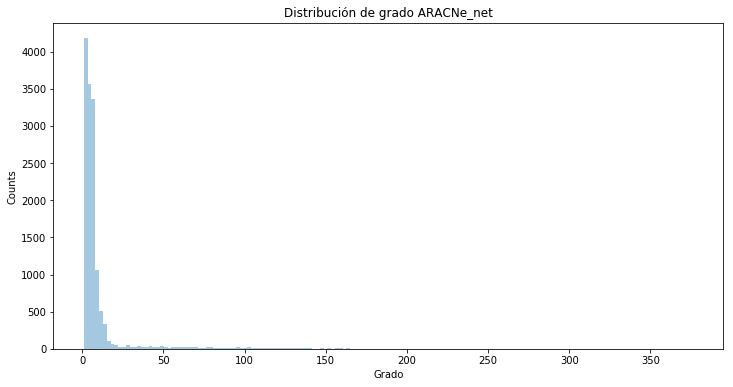

In [53]:
#Graficamos la distribución de grado para la red completa
plt.rcParams['figure.figsize'] = (12,6)
sns.distplot(degree_sequence_ARACNe_net, bins=160, kde=False, norm_hist=False)#, shade=True)
plt.title("Distribución de grado ARACNe_net")
plt.xlabel('Grado')
plt.ylabel('Counts')
plt.show()

In [54]:
import powerlaw as powerlaw2
from scipy.stats import powerlaw as powerlaw3
from scipy import optimize
from scipy import stats

Verificamos que la red sea libre de escala, tal y como se menciona en bibliografía, a través del ajuste a una power law

In [55]:
start = 20
dhist = np.array( nx.degree_histogram(ARACNe_net)[start:])

In [56]:
bins = 400
xdata = np.logspace(np.log10(start),np.log10(len(dhist) ) , bins)
ydata = np.histogram(dhist,bins = np.logspace(0,np.log10(len(dhist) ) , bins+1))[0]

xdata = np.array([i for i,j in zip(xdata,ydata) if j!=0])
ydata = np.array([i for i in ydata if i!=0])

#  y = a * x^b
#  log(y) = log(a) + b*log(x)


logx = np.log10(xdata + 1)
logy = np.log10(ydata + 1)

# define our (line) fitting function
powerlaw = lambda x, amp, index: amp * (x**index)

slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)

c = 10*intercept

print('y = %5.2f * x^%5.2f   R2: %2.2f ' % (intercept,slope,r_value**2)  )

y =  4.47 * x^-2.04   R2: 0.79 


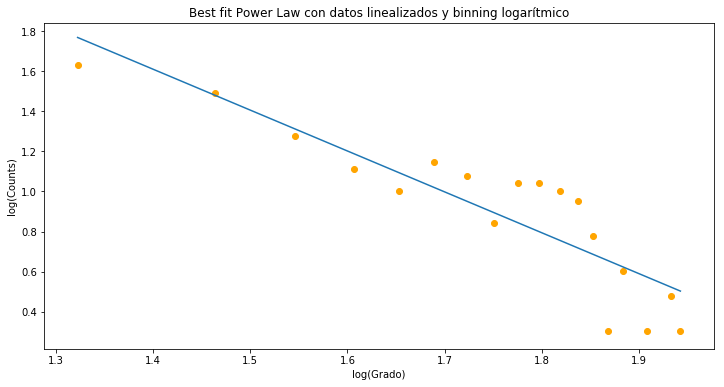

In [57]:
x = np.linspace(logx[0],logx[-1],1000)
y = [i*slope+intercept for i in x]

plt.plot(x, y)
plt.scatter(logx, logy, c='orange')  # Data

plt.title('Best fit Power Law con datos linealizados y binning logarítmico')
plt.xlabel('log(Grado)')
plt.ylabel('log(Counts)')
#plt.ylim(0.2,1.7)
plt.show()

El mal ajuste puede deberse a que estamos lidiando con una red bipartita. Sólo los factores de transcripción pueden regular genes.

Qué pasa si vemos la distribución de grado de los TFs (lo cual es equivalente a estudiar la distribución de Kout en el grafo dirigido)?

# Resultados de expresión diferencial

In [58]:
#Cargamos los resultados de expresión diferencial obtenidos con DESeq2 en R para todas las muestras, para BRAF y para RAS like
DE_all = pd.read_csv('DataDEG_all_paired_samples.tsv', sep='\t')
DE_BRAF = pd.read_csv('DataDEG_BRAF_paired_samples.tsv', sep='\t')
DE_RAS = pd.read_csv('DataDEG_RAS_paired_samples.tsv', sep='\t')

In [59]:
DE_all.head()

,mRNA,logFC,FDR,NT,TP,Delta
MAP3K12,MAP3K12,7.036613,0.000000e+00,56372.396552,7.559213e+06,396670.743598
VARS2,VARS2,6.348734,8.883460e-309,2074.948276,1.972755e+05,13173.295153
P2RX1,P2RX1,5.628921,1.377294e-259,8546.120690,4.023338e+05,48105.441893
SPRED1,SPRED1,5.605303,4.180294e-258,4579.172414,2.039114e+05,25667.648795
CDC42BPA,CDC42BPA,5.521321,1.682006e-252,27200.551724,1.345510e+06,150182.989221


In [60]:
#FC=1.25
DE_all_dict = {k:v for k,v in zip(DE_all['mRNA'],DE_all['logFC'])}
DE_BRAF_dict = {k:v for k,v in zip(DE_BRAF['mRNA'],DE_BRAF['logFC'])}
DE_RAS_dict = {k:v for k,v in zip(DE_RAS['mRNA'],DE_RAS['logFC'])}

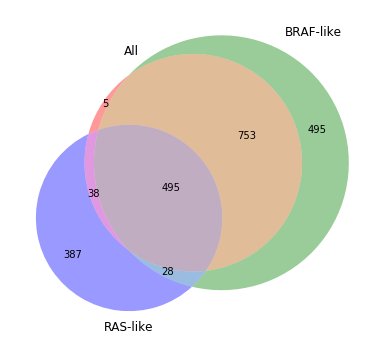

In [61]:
#Hago un diagrama de Venn con las keys de los tres diccionarios. Qué tanto se parecen los DEGs en los tres casos?
plt.rcParams['figure.figsize'] = (12,6)

#Diagrama de Venn para ver solapamiento entre variantes de las tres bases de datos
from matplotlib_venn import venn3

# Diagrama de Venn para FC=1.25
v=venn3(subsets = ([set(DE_all_dict.keys()),set(DE_BRAF_dict.keys()),set(DE_RAS_dict.keys())]),
        set_labels = ('All', 'BRAF-like', 'RAS-like'))

plt.show() 

In [62]:
#Cargamos las signatures del MRA. A cada gen y en cada comparación (all, BRAF, RAS) se le asigna un valor entre sobreexpresado
#en cáncer (signature > 1), estable (-1 < signature < 1) y subexpresado en cáncer (signature < -1).
MRA_DEG_df = pd.read_csv('RMA_DEG_signatures.tsv', sep='\t')
MRA_DEG_df = MRA_DEG_df[np.invert(MRA_DEG_df.index.duplicated())]
MRA_DEG_df.loc['NFKB2']

mrs_all_DEGs     3.105801
mrs_BRAF_DEGs    3.878494
mrs_RAS_DEGs    -0.483837
Name: NFKB2, dtype: float64

In [63]:
#Cargamos el logFC como atributo de la red, para cada uno de los tres análisis realizados. 
#Va a ser usado para graficar las redes ego
DE_all_net, DE_BRAF_net, DE_RAS_net = {}, {}, {}
for node in tqdm(ARACNe_net.nodes()):
    #Actualizo all dict
    value = MRA_DEG_df['mrs_all_DEGs'][node]
    
    if value > 1 or value < -1:
        DE_all_net[node] = int(value/np.abs(value))
    else:    
        DE_all_net[node] = 0
        
    #Actualizo BRAF dict
    value = MRA_DEG_df['mrs_BRAF_DEGs'][node]
   
    if value > 1 or value < -1:
        DE_BRAF_net[node] = int(value/np.abs(value))
    else:    
        DE_BRAF_net[node] = 0
    
    #Actualizo all dict
    value = MRA_DEG_df['mrs_RAS_DEGs'][node]
    
    if value > 1 or value < -1:
        DE_RAS_net[node] = int(value/np.abs(value))
    else:    
        DE_RAS_net[node] = 0

In [64]:
DE_all_net['PEG3']

-1

In [65]:
nx.set_node_attributes(ARACNe_net, DE_all_net, 'DEall')
nx.set_node_attributes(ARACNe_net, DE_BRAF_net, 'DEBRAF')
nx.set_node_attributes(ARACNe_net, DE_RAS_net, 'DERAS')

In [66]:
#Guardo la red como GML para cargarla en gephi
nx.write_gml(ARACNe_net, 'ARACNe_net.gml')

# Resultados del RMA

In [67]:
#Cargamos los resultados del análisis de Reguladores Maestros obtenidos con VIPER en R para todas las muestras,
#para BRAF y para RAS like
RMA_all = pd.read_csv('RMA_results_all.tsv', sep='\t')
RMA_BRAF = pd.read_csv('RMA_results_BRAF.tsv', sep='\t')
RMA_RAS = pd.read_csv('RMA_results_RAS.tsv', sep='\t')

In [68]:
#Cargamos los resultados de shadowing para el análisis de Reguladores Maestros.
RMA_all_shadow = pd.read_csv('RMA_shadow_all.tsv', sep='\t')
RMA_BRAF_shadow = pd.read_csv('RMA_shadow_BRAF.tsv', sep='\t')
RMA_RAS_shadow = pd.read_csv('RMA_shadow_RAS.tsv', sep='\t')

In [69]:
RMA_all.head()

,Regulon,Size,NES,p.value,FDR,Synergy,Ledge
ETV4,ETV4,154,4.49,0.000007,0.00303,NaN,"RNF24, IGF2BP2, GALNT7, RAD23B, + 151 genes"
LRRFIP2--GZF1,LRRFIP2--GZF1,27,4.22,0.000024,0.00437,0.000011,NaN
ETV5,ETV5,95,4.09,0.000043,0.00653,NaN,"IGF2BP2, PPP5C, AGPAT4, KIAA1211L, + 77 genes"
RARA,RARA,222,3.87,0.000110,0.00911,NaN,"LRIG1, BMP1, SEMA4C, FTCDNL1, + 232 genes"
NR1D1,NR1D1,33,3.85,0.000116,0.00911,NaN,"B3GNT7, PLA2R1, TBC1D4, TDRKH-AS1, + 28 genes"


In [70]:
RMA_all_shadow.head()

,x
1,ETV4 -> RARA
2,TFCP2L1 -> SMAD9
3,TFCP2L1 -> HEY2
4,TFCP2L1 -> RXRG
5,ZFP36L2 -> ZFPM2


# Extraemos las listas de genes de las redes ego para cargar en DAVID

In [98]:
PEG3_ego = [node for node in nx.ego_graph(ARACNe_net, 'PEG3').nodes()]
RARG_ego = [node for node in nx.ego_graph(ARACNe_net, 'RARG').nodes()]
TFCP2L1_ego = [node for node in nx.ego_graph(ARACNe_net, 'TFCP2L1').nodes()]

In [103]:
PEG3_PATHWAYS = pd.read_csv('PEG3_KEGG_chart.txt', sep='\t')
PEG3_TISSUE = pd.read_csv('PEG3_TISSUE_chart.txt', sep='\t')
PEG3_PATHWAYS

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,KEGG_PATHWAY,hsa05169:Epstein-Barr virus infection,10,3.030303,0.000275,"USP7, RELA, BCL2, CD58, ENTPD8, HLA-A, HLA-C, ...",122,122,6879,4.621741,0.047538,0.047538,0.337416
1,KEGG_PATHWAY,hsa05168:Herpes simplex infection,10,3.030303,0.004789,"USP7, RELA, TICAM1, TAP1, HLA-A, HLA-C, MAPK8,...",122,183,6879,3.081161,0.572422,0.346105,5.725474
2,KEGG_PATHWAY,hsa05166:HTLV-I infection,12,3.636364,0.004927,"E2F1, EGR1, CDKN2A, RELA, HLA-A, RRAS, HLA-C, ...",122,254,6879,2.663870,0.582827,0.252797,5.886517
3,KEGG_PATHWAY,hsa04612:Antigen processing and presentation,6,1.818182,0.010601,"TAP1, HLA-A, HLA-C, HLA-B, CANX, CD74",122,76,6879,4.451467,0.848382,0.375996,12.269982
4,KEGG_PATHWAY,hsa05131:Shigellosis,5,1.515152,0.025748,"NOD1, BTRC, RELA, MAPK8, RHOG",122,64,6879,4.405097,0.990119,0.602848,27.414807
5,KEGG_PATHWAY,hsa05212:Pancreatic cancer,5,1.515152,0.027075,"E2F1, CDKN2A, RELA, MAPK8, BCL2L1",122,65,6879,4.337327,0.992237,0.555019,28.619400
6,KEGG_PATHWAY,hsa04330:Notch signaling pathway,4,1.212121,0.051804,"DTX4, DTX2, NUMB, DVL1",122,48,6879,4.698770,0.999919,0.739475,47.971650
7,KEGG_PATHWAY,hsa00900:Terpenoid backbone biosynthesis,3,0.909091,0.056381,"NUS1, HMGCR, HMGCS1",122,22,6879,7.688897,0.999965,0.723065,50.973502
8,KEGG_PATHWAY,hsa04142:Lysosome,6,1.818182,0.061600,"NPC2, GALC, CTSD, CTSA, CTSC, CTSH",122,121,6879,2.795963,0.999987,0.713607,54.202287
9,KEGG_PATHWAY,hsa04064:NF-kappa B signaling pathway,5,1.515152,0.066601,"RELA, BCL2, TICAM1, BCL2L1, PLAU",122,87,6879,3.240531,0.999995,0.704749,57.111605


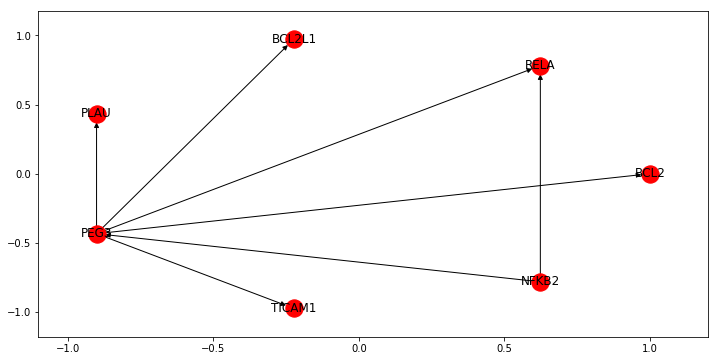

In [122]:
nfkb_genes =  ["PEG3","RELA", "BCL2", "TICAM1", "BCL2L1", "PLAU","NFKB2"]

G = ARACNe_net.subgraph( nfkb_genes )
pos = nx.circular_layout(G)
nx.draw_networkx(G,label=True,pos=pos)
nx.write_gml(G,"NFkB_subgraph.gml")


In [120]:
list(G.edges())

[('PEG3', 'BCL2'),
 ('PEG3', 'BCL2L1'),
 ('PEG3', 'PLAU'),
 ('PEG3', 'RELA'),
 ('PEG3', 'TICAM1'),
 ('NFKB2', 'PEG3'),
 ('NFKB2', 'RELA')]